In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import time
import warnings
warnings.filterwarnings('ignore')
factors = ['Beta60', 'OperatingRevenueGrowRate', 'NetProfitGrowRate', 'NetCashFlowGrowRate', 'NetProfitGrowRate5Y', 'TVSTD20',
           'TVSTD6', 'TVMA20', 'TVMA6', 'BLEV', 'MLEV', 'CashToCurrentLiability', 'CurrentRatio', 'REC', 'DAREC', 'GREC',
           'DASREV', 'SFY12P', 'LCAP', 'ASSI', 'LFLO', 'TA2EV', 'PEG5Y', 'PE', 'PB', 'PS', 'SalesCostRatio', 'PCF', 'CETOP',
           'TotalProfitGrowRate', 'CTOP', 'MACD', 'DEA', 'DIFF', 'RSI', 'PSY', 'BIAS10', 'ROE', 'ROA', 'ROA5', 'ROE5',
           'DEGM', 'GrossIncomeRatio', 'ROECut', 'NIAPCut', 'CurrentAssetsTRate', 'FixedAssetsTRate', 'FCFF', 'FCFE', 'PLRC6',
           'REVS5', 'REVS10', 'REVS20', 'REVS60', 'HSIGMA', 'HsigmaCNE5', 'ChaikinOscillator', 'ChaikinVolatility', 'Aroon',
           'DDI', 'MTM', 'MTMMA', 'VOL10', 'VOL20', 'VOL5', 'VOL60', 'RealizedVolatility', 'DASTD', 'DDNSR', 'Hurst']

df_ori = pd.read_csv('dataset_factorRank10.csv')

In [3]:
data_batch = []
tdate = np.unique(df_ori['tradeDate'].values)# 共计130个月
for i in range(0,56):
    mark1 = tdate[i]
    mark2 = tdate[74+i]
    batch = df_ori[(df_ori['tradeDate']>=mark1) & (df_ori['tradeDate']<=mark2)]
    data_batch.append(batch)
    
def train_test_dev(i):
    batch = data_batch[i]
    tdate_sub = np.unique(batch['tradeDate'].values)
    
    cut1 = tdate_sub[74]
    cut2 = tdate_sub[72]
    cut3 = tdate_sub[67]
    test_df = batch[batch['tradeDate']==cut1]
    leave = batch[batch['tradeDate']<cut1]
    
    print('cut1:',cut1)

    # 用于训练的数据都屏蔽掉label为0的情况,并把label为-1的替换为0
    leave = leave[leave['label']!=0]
    leave.loc[:,'label'] = leave.loc[:,'label'].apply(lambda x:0 if x ==-1 else x)

    train_df_lr = leave[(leave['tradeDate']>=cut3) & (leave['tradeDate']<=cut2)]
    train_df_xgb = leave[leave['tradeDate'] < cut2]
    dev_df = leave[(leave['tradeDate']>=cut2) & (leave['tradeDate']<cut1)]

    return train_df_xgb,train_df_lr,dev_df,test_df
    
def train_predict(i):
    train_df_xgb,train_df_lr,dev_df,test_df = train_test_dev(i)

    train_x_xgb = train_df_xgb[factors]
    train_y_xgb = train_df_xgb['label']
    train_x_lr = train_df_lr[factors]
    train_y_lr = train_df_lr['label']
    dev_x = dev_df[factors]
    dev_y = dev_df['label']
    test_x = test_df[factors]

    xgb = XGBClassifier(max_depth = 11,
                    learning_rate = 0.01,
                    n_estimators = 246 ,
                    min_child_weight = 17, 
                    gamma = 0.66 ,
                    subsample =0.60,
                    colsample_bytree = 0.69,
                    reg_alpha = 0.45,
                    reg_lambda = 0.75,
                    n_jobs = 10,
                    verbose = 0)
    xgb.fit(train_x_xgb,train_y_xgb)
    predict_y1 = xgb.predict_proba(dev_x)

    lr1 = LogisticRegression(C= 0.01,max_iter = 50,fit_intercept = True,penalty = 'l2',verbose = 0)
    lr1.fit(train_x_xgb,train_y_xgb)
    predict_y2 = lr1.predict_proba(dev_x)

    new_feature_dev = pd.DataFrame()
    new_feature_dev['1'] = xgb.predict_proba(dev_x)[:,1]
    new_feature_dev['2'] = lr1.predict_proba(dev_x)[:,1]
   
    lr2 = LogisticRegression()
    lr2.fit(new_feature_dev,dev_y)
    
    # print('train process is done,start predict')
    
    new_feature_test = pd.DataFrame()
    new_feature_test['1'] = xgb.predict_proba(test_x)[:,1]
    new_feature_test['2'] = lr1.predict_proba(test_x)[:,1]
  
    predict_score = lr2.predict_proba(new_feature_test)[:,1]
    
    #print('predict is done')
    return predict_score
    
def result_summary(df):
    tdate = np.unique(df_ori['tradeDate'].values)
    df = df[df['tradeDate']>=tdate[74]]
    i = 0
    new_df = None
    for tdate,group in df.groupby('tradeDate'):
        print('round:',i)
        result = train_predict(i)
        print('tdate:',tdate)

        group.loc[:,'factor'] = result
        i += 1
        
        if new_df is None:
            new_df = group
        else:
            new_df = pd.concat([new_df, group],ignore_index=True)
    return new_df

In [4]:
new_df = result_summary(df_ori)

round: 0
cut1: 20130329
tdate: 20130329
round: 1
cut1: 20130426
tdate: 20130426
round: 2
cut1: 20130531
tdate: 20130531
round: 3
cut1: 20130628
tdate: 20130628
round: 4
cut1: 20130731
tdate: 20130731
round: 5
cut1: 20130830
tdate: 20130830
round: 6
cut1: 20130930
tdate: 20130930
round: 7
cut1: 20131031
tdate: 20131031
round: 8
cut1: 20131129
tdate: 20131129
round: 9
cut1: 20131231
tdate: 20131231
round: 10
cut1: 20140130
tdate: 20140130
round: 11
cut1: 20140228
tdate: 20140228
round: 12
cut1: 20140331
tdate: 20140331
round: 13
cut1: 20140430
tdate: 20140430
round: 14
cut1: 20140530
tdate: 20140530
round: 15
cut1: 20140630
tdate: 20140630
round: 16
cut1: 20140731
tdate: 20140731
round: 17
cut1: 20140829
tdate: 20140829
round: 18
cut1: 20140930
tdate: 20140930
round: 19
cut1: 20141031
tdate: 20141031
round: 20
cut1: 20141128
tdate: 20141128
round: 21
cut1: 20141231
tdate: 20141231
round: 22
cut1: 20150130
tdate: 20150130
round: 23
cut1: 20150227
tdate: 20150227
round: 24
cut1: 20150331
t

In [5]:
newdf = new_df.loc[:, ['ticker', 'tradeDate', 'label', 'factor']]

In [6]:
newdf.to_csv('stacking_xgb0524.csv')

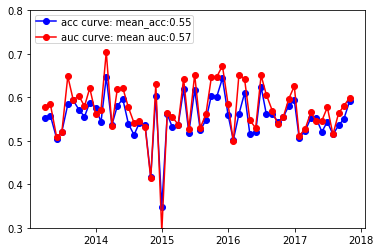

In [91]:
from datetime import datetime
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

def get_test_auc_acc(filename):
    '''
    计算二分类模型样本外的ACC与AUC，按照日期统计
    返回:
        acc_list: 样本外的预测准确率集合
        auc_list: 样本外的预测AUC集合
        mean_acc: 样本外的平均预测准确率
        mean_auc: 样本外的平均预测AUC
    '''
    
    df = pd.read_csv(filename)
    #只查看原有label为+1, -1的数据
    df = df[df['label'] != 0]
    df.loc[:, 'predict'] = df.loc[:, 'factor'].apply(lambda x : 1 if x > 0.5 else -1)

    acc_list = []  #保存每个月份的准确率
    auc_list = []  #保存每个月份的AUC指标
    for date, group in df.groupby('tradeDate'):
        df_correct = group[group['predict'] == group['label']]
        correct = len(df_correct) * 1.0 / len(group)
        auc =  roc_auc_score(np.array(group['label']), np.array(group['factor']))
        acc_list.append([date, correct])
        auc_list.append([date, auc])
        
    acc_list = sorted(acc_list, key=lambda x: x[0], reverse=False)
    mean_acc = sum([item[1] for item in acc_list]) / len(acc_list)
    
    auc_list = sorted(auc_list, key=lambda x: x[0], reverse=False)
    mean_auc = sum([item[1] for item in auc_list]) / len(auc_list)
    
    return acc_list, auc_list, round(mean_acc, 2), round(mean_auc, 2)

def plot_accuracy_curve(filename):
    '''
    画图
    '''
    acc_list, auc_list, mean_acc, mean_auc = get_test_auc_acc(filename)

    plt.plot([datetime.strptime(str(item[0]), '%Y%m%d') for item in acc_list], [item[1] for item in acc_list], '-bo')
    plt.plot([datetime.strptime(str(item[0]), '%Y%m%d') for item in auc_list], [item[1] for item in auc_list], '-ro')

    plt.legend([u"acc curve: mean_acc:%s"%mean_acc, u"auc curve: mean auc:%s"%mean_auc], loc='upper left', handlelength=2, handletextpad=0.5, borderpad=0.1)
    plt.ylim((0.3, 0.8))
    plt.show()

plot_accuracy_curve( "stacking10_2.csv")

In [99]:
df = pd.DataFrame({'foo': ['one','one','one','two','two','two'],
                       'bar': [ 'A', 'B', 'C', 'A', 'B', 'C'],
                       'baz': [1, 2, np.nan, 4, 5, 6]})
df.pivot(index='foo', columns='bar', values='baz')

bar,A,B,C
foo,,,
one,1.0,2.0,NaN
two,4.0,5.0,6.0
